<a href="https://colab.research.google.com/github/SooMiiii/24-1-ESAA/blob/main/0318_%ED%95%B8%EC%A6%88%EC%98%A8_CH7_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 머신러닝 7장 앙상블 학습과 랜덤 포레스트

---

# CHAPTER 7 앙상블과 랜덤 포레스트

`대중의 지혜` : 무작위로 선택된 수천 명의 사람에게 질문해서 모은 답이 전문가의 답보다 낫다.

-> 일련의 예측기(`앙상블`)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것. : `앙상블 학습`

-> `앙상블 방법` : 앙상블 학습 알고리즘

결정 트리의 앙상블 : `랜덤 포레스트`
- 모든 개별 트리의 예측 구하기

배깅, 부스팅, 스태킹 등 인기 있는 앙상블 방법을 보도록 하자.




## 7.1 투표 기반 분류기
더 좋은 분류기를 만드는 간단한 방법 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것.

  -> `직접 투표` 분류기 : 이렇게 다수결로 정해지는 분류기


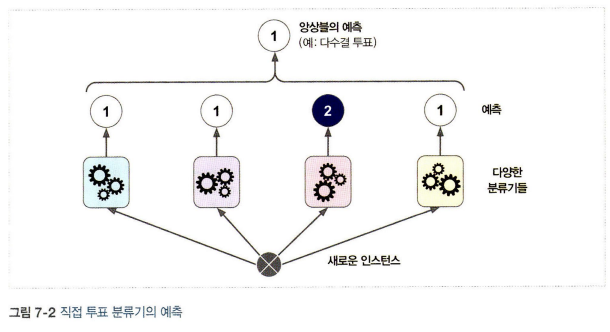

- 뛰어난 개별 분류기보다 정확도가 높은 경우가 많다.
- 각 분류기가 `약한 학습기`일지라도 충분하게 많고 다양하다면 앙상블은 `강한 학습기`가 될 수 있다.

앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

- 여러 분류기를 조합해 사이킷런의 VotingClassifier 만들고 훈련

In [3]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.9
SVC 0.95
VotingClassifier 0.9


`간접 투표`
- 모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba() 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다.
- 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다.
- 이 방식을 사용하려면 voting="hard"를 voting="soft" 로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다.
- SVC는 기본값에서 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 한다.

## 7.2 배깅과 페이스팅

다양한 분류기를 만드는 방법
>- 각기 다른 훈련 알고리즘 사용
>- 같은 알고리즘을 사용, 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것

`배깅` : 훈련 세트에서 중복을 허용하여 샘플링하는 방식(bootstrap aggregating)

`페이스팅` : 중복을 허용하지 않고 샘플링하는 방식

- 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다.
- 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다.


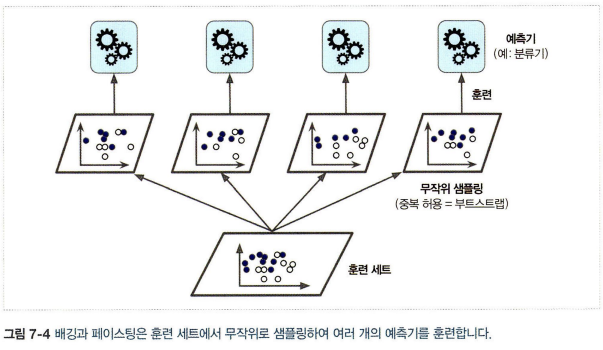

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
- 수집함수는 분류일 때는 `최빈값`, 회귀일 때는 `평균`을 계산한다.
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것 보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다.
- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.
- 배깅과 페이스팅 모두 병렬로 학습시킬 수 있다.

### 7.2.1 사이킷런의 배깅과 페이스팅


사이킷런은 `BaggingClassifier`(`BaggingRegressor`) 제공

- 페이스팅 사용하려면 `bootstrap=False`로 지정
- `n_jobs` : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정(-1 : 가용한 모든 코어 사용)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- BaggingClassifier는 기반이 되는 분류기가 클래스 확률을 추정할 수 있으면(predict_proba() 함수 있으면) 직접 투표 대신 자동으로 간접 투표 방식 사용

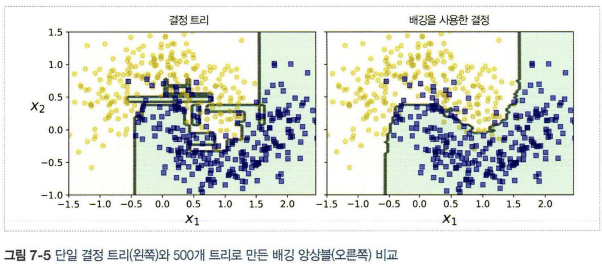

- 앙상블 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같다.
- 앙상블은 비슷하 편향에서 더 작은 분산을 만든다. (훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다.)
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성 증가시킴 -> 배깅이 페이스팅보다 편향이 조금 더 높다.
- 다양성을 추가한다는 것 : 예측기들의 상관관계를 줄인다 -> 앙상블의 분산을 감소시킨다.
- 전반적으로 배깅을 더 선호(더 나은 모델) ->
시간과 CPU 파워에 여유가 있다면 교차 검정으로 배깅과 페이스팅을 모두 평가해서 더 나은쪽을 선택하는 것이 좋다.


### 7.2.2 oob 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
- BaggingClassifier는 기본값으로 중복을 허용하여 (bootstrap=True) 훈련 세트의 크기만큼 m개 샘플 선택
- 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미
- 선택되지 않은 나머지 37%를 oob 샘플이라고 부른다.
- 예측기마다 남겨진 37%는 모두 다르다.

예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.
- 사이킷런에서 BaggingClassifier 만들 때 oob_score=True 지정하면 훈련 끝난 후 자동으로 oob 평가 수행
- 평가 점수 결과는 oob_score_ 변수에 저장

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인 가능
- 결정 함수는 각 훈련 샘플의 클래스 확률 반환

In [7]:
bag_clf.oob_decision_function_

array([[0.90163934, 0.09836066],
       [0.94054054, 0.05945946],
       [0.15656566, 0.84343434],
       [1.        , 0.        ],
       [0.01666667, 0.98333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.53763441, 0.46236559],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.00478469, 0.99521531],
       [0.00555556, 0.99444444],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.14117647, 0.85882353],
       [1.        , 0.        ],
       [0.01069519, 0.98930481],
       [0.        , 1.        ],
       [0.01030928, 0.98969072],
       [0.8       , 0.2       ],
       [0.00546448, 0.99453552],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.01666667, 0.98333333],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.93908629, 0.06091371],
       [0.

- 첫 번째 훈련 샘플이 양성 클래스에 속할 확률 : 93%로 추정

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원
- max_features, bootstrap_features 두 매개변수로 조절
- 작동 방식은 max_amples, bootstrap과 동일
- 샘플이 아니고 특성에 대한 샘플링 -> 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련
- 매우 고차원의 데이터셋 다룰 때 유용
- `랜덤 패치 방식` : 훈련 특성과 샘플을 모두 샘플링하는 것
- `랜덤 서브스페이스 방식` : 훈련 샘플을 모두 사용(bootstrap=False, max_samples=1.0)하고 특성은 샘플링(bootstrap_features=True, max_features < 1.0)하는 것

-> 특성 샘플링은 더 다양한 예측기 만들며 편향 늘리는 대신 분산 낮춘다.

## 7.4 랜덤 포레스트

- 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
- max_samples를 훈련 세트의 크기로 지정
- RandomForestClassifier. RandomForestRegressor 사용

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 트리 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입

-> 트리 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트리 트리

- 랜덤 포레스트에서 트리 만들 때 각 노드는 무작위로 특성의 서브셋 만들어 분할에 사용 -> 더욱 무작위하게 만들기 위해 최적의 임곗값 찾는 대신 후보 특성 사용해 무작위 분할 후 최상의 분할 선택

`익스트림 랜덤 트리`(`엑스트라 트리`)
- 극단적으로 무작위한 트리의 랜덤 포레스트
- 편향이 늘어나지만 분산을 낮춘다.
- 모든 노드에서 특성마다 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업이므로 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.
- 사이킷런의 ExtraTreesClassifier 사용


### 7.4.2 특성 중요도

- 랜덤 포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉽다는 것

- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정

-> 더 정확히 말하면 가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플수와 같다.

- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값 정규화. 이 값은 feature_importances_ 변수에 저장

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.08927607934973784
sepal width (cm) 0.02205361532785241
petal length (cm) 0.4441083322697641
petal width (cm) 0.44456197305264566


- 가장 중요한 특성 : petal length,(44%), ppetal width(44%)

## 7.5 부스팅

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 부스팅 방법의 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
- 에이다부스트, 그레디언트 부스팅

### 7.5.1 에이다부스트

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법 : 이전 모델이 과소적합 했던 훈련 샘플의 가중치를 더 높이는 것

-> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.


예) 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측 만들기 -> 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높이기 -> 두 번째 분류기는 업데이트된 가중치 사용해 훈련 세트에서 훈련하고 다시 예측 만들기 -> 다시 가중치 업데이트하는 식으로 계속



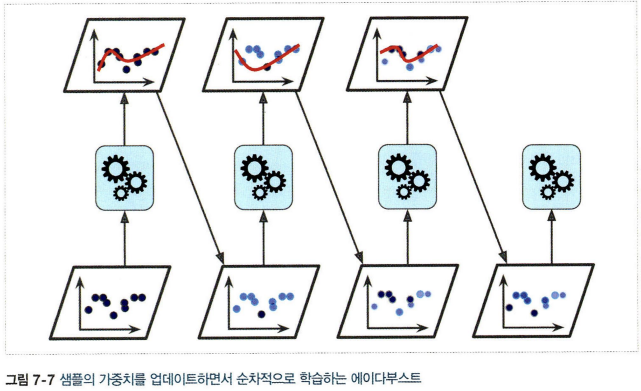

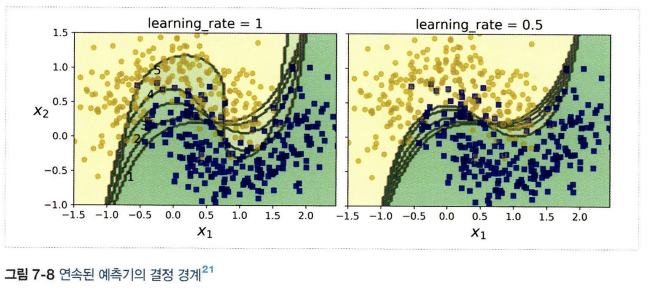

경사 하강법과 비슷한 면이 있다.
- 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해간다.
- 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기 추가

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 에측을 만든다.
- 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.
- 예측기가 정확할수록 가중치가 더 높아지게 된다.(무작위 : 가중치가 0에 가까울 것, 그보다 나쁘면 가중치는 음수가 된다,)

각 샘플의 가중치 초기화 -> 첫 번째 예측기 학습 -> 훈련 세트에 대한 에러율 계산 -> 샘플의 가중치 업데이트 -> 모든 샘플의 가중치 정규화 -> 새 예측기가 업데이트된 가중치 사용해 훈련되고 전체 과정이 반복 -> 지정된 에측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지.

- 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전 사용
- 클래스가 두 개뿐일 때는 SAMME가 에디아부스트와 동일

- 예측기가 클래스의 확률을 추정할 수 있다면(predict_proba() 메서드가 있다면) 사이킷런은 SAMME.R이라는 변종 사용
> 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다


In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

- 사이킷런의 AdaBoostClassifier 사용하여 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기 훈련

### 7.5.2 그레이디언트 부스팅

에이다부스트처럼 그레디이디언트 부스팅은 앙상블에 이전까지 오차를 보정하도록 예측기를 순차적으로 추가
- 에이다부스트 : 샘플의 가중치 수정
- 그레디이언트부스팅 : 이전 예측기가 만든 잔여 오차에 새로운 예측기 학습

In [12]:
# DecisionTreeRegressor를 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [13]:
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측 더하면 된다.

In [15]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

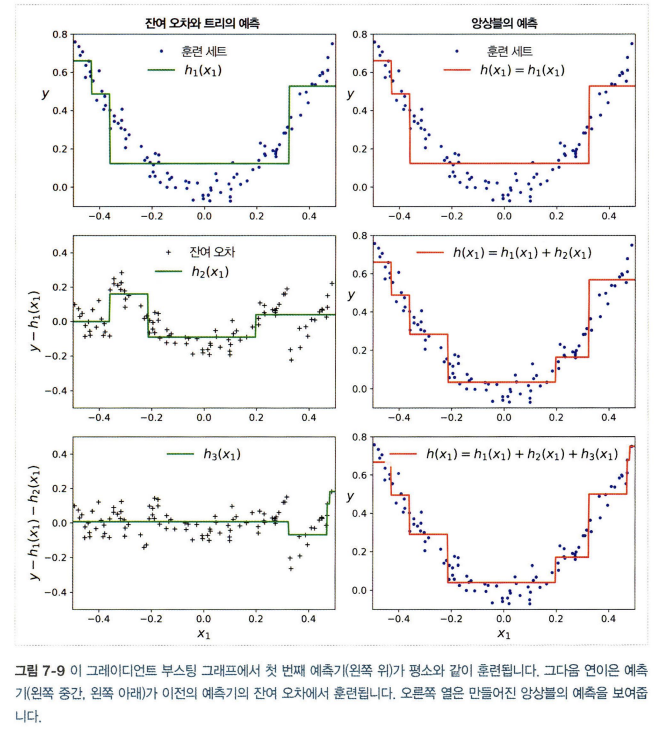

- 첫 번째 행 : 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같다.
- 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습
- 서 번째 행에서는 또 다른 츠리가 두 번째 트리의 잔여 오차에 훈련되었다.
- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

사이킷런의 GradientBoostingRegressor 사용해 GBRT 앙상블 훈련
- 매개변수 max_depth, min_samples_leaf

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

learning_rate 매개변수
- 각 트리의 기여 정도 조절
- 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리 필요하지만 일반적으로 예측 성능은 좋아진다 : `축소` 라는 규제 방법

staged_predict() 메서드
- 최적의 트리 수를 찾기 위해서는 조기 종료 기법 사용
- 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환

In [17]:
# 120개의 트리로 GBRT 앙상블 훈련
# -> 최적의 트리 수 찾기 위해 각 훈련 단게에서 검증 오차 측정
# -> 새로운 GBRT 앙상블 훈련
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=112)

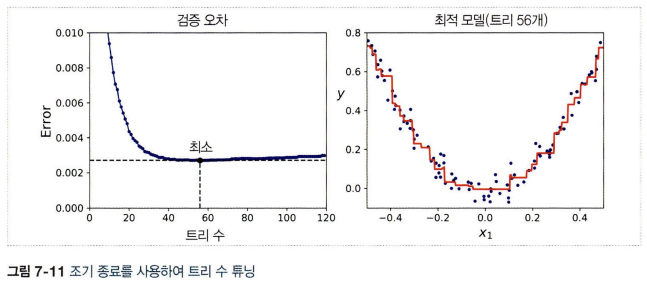

- 훈련을 중지하는 방법으로 조기종료를 구현할 수 있다.
- warm_start=True로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 한다.

In [18]:
# 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다.
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break #조기종료

GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개 변수도 지원한다.

예) subsample=0.25 -> 25%의 무작위 선택된 훈련 샘플로 학습 -> 편향 높아지고 분산 낮아짐, 훈련속도 높아짐 : `확률적 그레디언트 부스팅`

최적화된 그레이디언트 부스팅 : XGBoost
- 목표 : 매우 빠른 속도, 확장성, 이식성



In [20]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [21]:
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.39700
[1]	validation_0-rmse:0.32179
[2]	validation_0-rmse:0.26462
[3]	validation_0-rmse:0.23191
[4]	validation_0-rmse:0.21989
[5]	validation_0-rmse:0.20973
[6]	validation_0-rmse:0.20774
[7]	validation_0-rmse:0.19409
[8]	validation_0-rmse:0.18310
[9]	validation_0-rmse:0.17369
[10]	validation_0-rmse:0.16627
[11]	validation_0-rmse:0.16500
[12]	validation_0-rmse:0.15974
[13]	validation_0-rmse:0.15538
[14]	validation_0-rmse:0.15178
[15]	validation_0-rmse:0.14882
[16]	validation_0-rmse:0.14633
[17]	validation_0-rmse:0.14447
[18]	validation_0-rmse:0.14450


- 자동 조기 종료와 같은 여러 기능 제공

## 7.6 스태킹

- stacked generalization의 줄임말
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없나? 라는 기본 아이디어로 출발한다.
- 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여준다.
- 예) 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(`블랜더`,`메타 학습기`)가 이 예측을 입력으로 받아 최종 예측을 만든다.

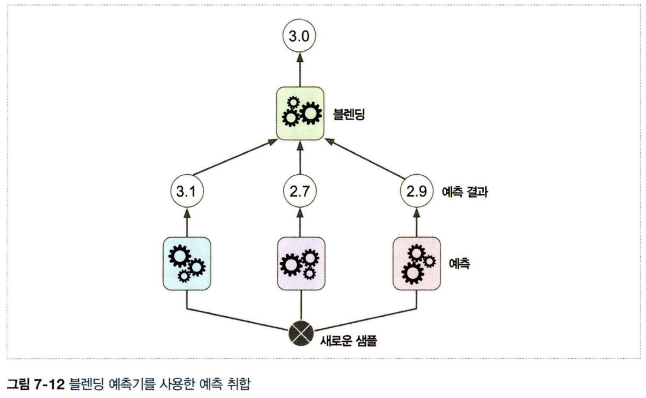

블렌더를 학습시키는 일반적인 방법 : 홀드 아웃 세트 사용

- 먼저 두 개의 서브셋으로 나눈다.
- 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용된다.

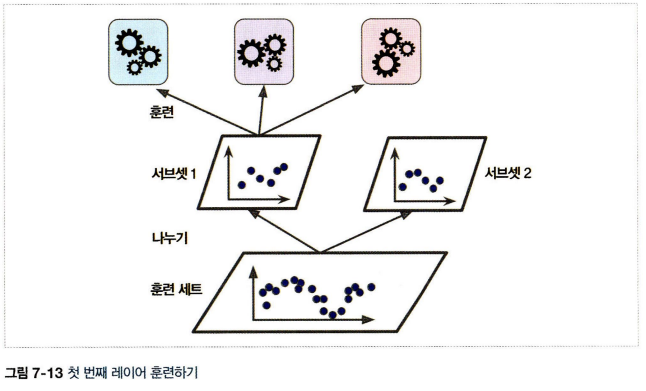

- 그런 다음에 첫 번째 레이어의 예측기를 사용해 두 번째 (홀드 아웃) 세트에 대한 예측을 만든다.
- 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다.
- 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다.
- 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.
- 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다.

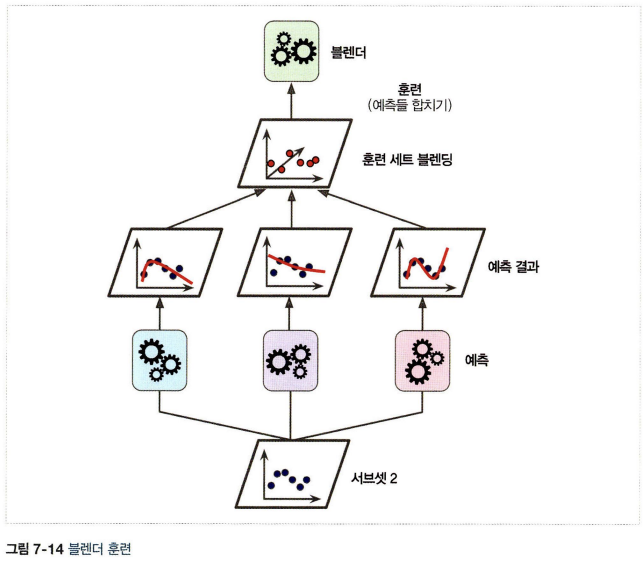

이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능하다.(예 : 하나는 선형 회귀, 다른 하나는 랜덤포레스트회귀로)

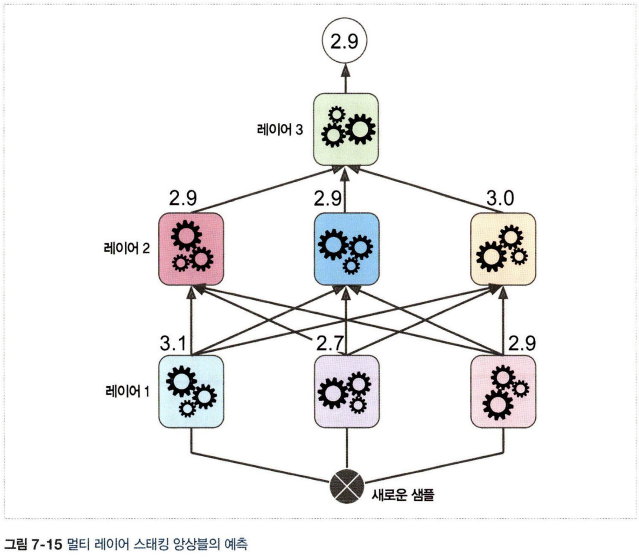